# Import and Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA


# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size']='14'

Load the Data

In [2]:
tegel = pd.read_csv('Berlin_Tegel.txt', header = 15, index_col = 2, sep = ',',
                      parse_dates = True, skipinitialspace=True ) #skipinitial space removes spaces 
tegel.head(2)

,STAID,SOUID,TG,Q_TG
DATE,,,,
1876-01-01,4005,27488,22,0
1876-01-02,4005,27488,25,0


# Analyse Data

In [3]:
tegel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53416 entries, 1876-01-01 to 2022-03-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   STAID   53416 non-null  int64
 1   SOUID   53416 non-null  int64
 2   TG      53416 non-null  int64
 3   Q_TG    53416 non-null  int64
dtypes: int64(4)
memory usage: 2.0 MB


In [4]:
# What datatype is the index and any elements of the index?
type(tegel.index[3]), type(tegel.index)

(pandas._libs.tslibs.timestamps.Timestamp,
 pandas.core.indexes.datetimes.DatetimeIndex)

In [5]:
tegel.columns

Index(['STAID', 'SOUID', 'TG', 'Q_TG'], dtype='object')

In [6]:
tegel.index

DatetimeIndex(['1876-01-01', '1876-01-02', '1876-01-03', '1876-01-04',
               '1876-01-05', '1876-01-06', '1876-01-07', '1876-01-08',
               '1876-01-09', '1876-01-10',
               ...
               '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25',
               '2022-03-26', '2022-03-27', '2022-03-28', '2022-03-29',
               '2022-03-30', '2022-03-31'],
              dtype='datetime64[ns]', name='DATE', length=53416, freq=None)

In [7]:
sortQ_TG=tegel.groupby('Q_TG')['Q_TG'].agg(['count']) #or tegel['Q_TG'].value_counts()
sortQ_TG

#quality code for TG (0='valid'; 1='suspect'; 9='missing')

,count
Q_TG,
0,53220
9,196


In [8]:
#I converted the -9999 to NaN to use ffill
df_tegel=tegel.replace(-9999, np.nan)

In [9]:
df=df_tegel.fillna(method='ffill')

In [10]:
#multiplied it by 0.1 to convert it to Celsius
df['temp']=df['TG']*0.1
#df.head(2)

In [11]:
dfn=df[df.index.year >= 1950]
#dfn.head(2)

### Heatmap to check for missing values

<AxesSubplot:ylabel='DATE'>

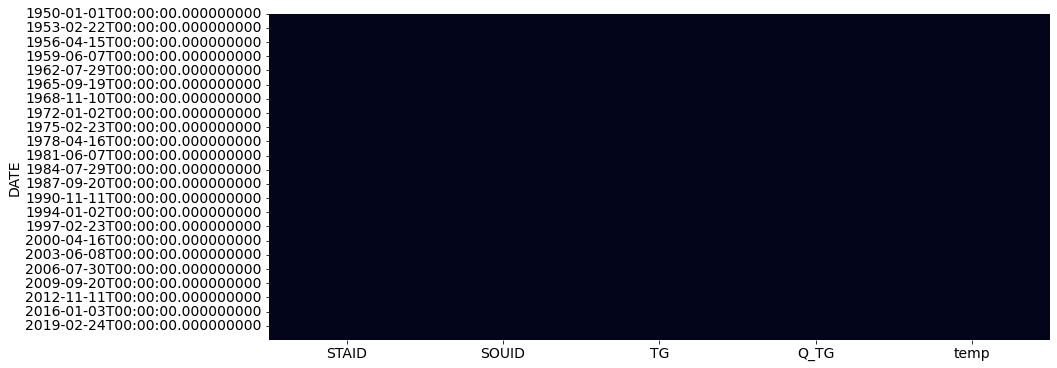

In [12]:
#see if missing values
sns.heatmap(dfn.isna(), cbar=False)

## Check Descriptive Statistics

In [13]:
dfn.describe()

,STAID,SOUID,TG,Q_TG,temp
count,26388.0,26388.000000,26388.000000,26388.000000,26388.000000
mean,4005.0,19791.724799,97.896468,0.000341,9.789647
std,0.0,6687.198559,78.465856,0.055404,7.846586
min,4005.0,133.000000,-181.000000,0.000000,-18.100000
25%,4005.0,21152.000000,38.000000,0.000000,3.800000
50%,4005.0,21152.000000,98.000000,0.000000,9.800000
75%,4005.0,21152.000000,160.000000,0.000000,16.000000
max,4005.0,27848.000000,308.000000,9.000000,30.800000


# Plot the Data

(-24.860000000000003, 33.88)

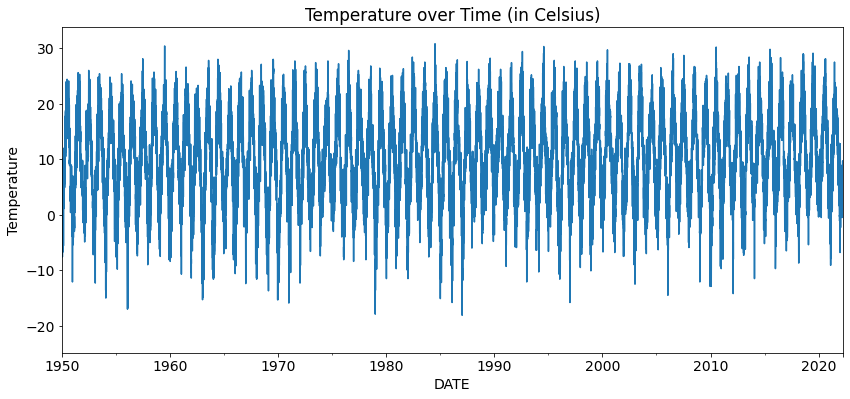

In [14]:
dfn['temp'].plot()
plt.title("Temperature over Time (in Celsius)")
plt.ylabel('Temperature')
plt.ylim([df['temp'].min()*1.1,df['temp'].max()*1.1])

(-24.860000000000003, 33.88)

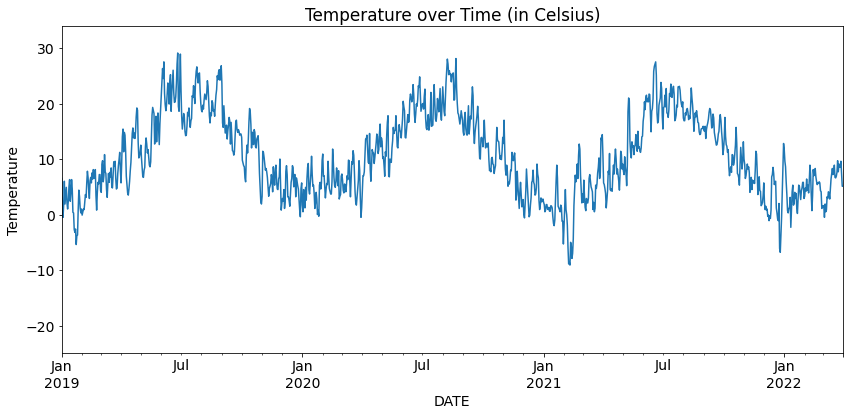

In [15]:
dfn[dfn.index.year >= 2019]['temp'].plot()
plt.title("Temperature over Time (in Celsius)")
plt.ylabel('Temperature')
plt.ylim([df['temp'].min()*1.1,df['temp'].max()*1.1])
#sns.despine()

Check the yearly mean temperature.

<AxesSubplot:xlabel='DATE'>

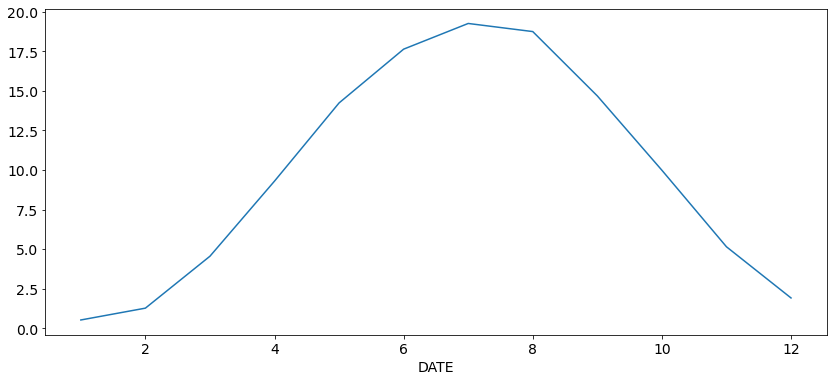

In [16]:
dfn.groupby(dfn.index.month)['temp'].mean().plot()

<AxesSubplot:xlabel='DATE'>

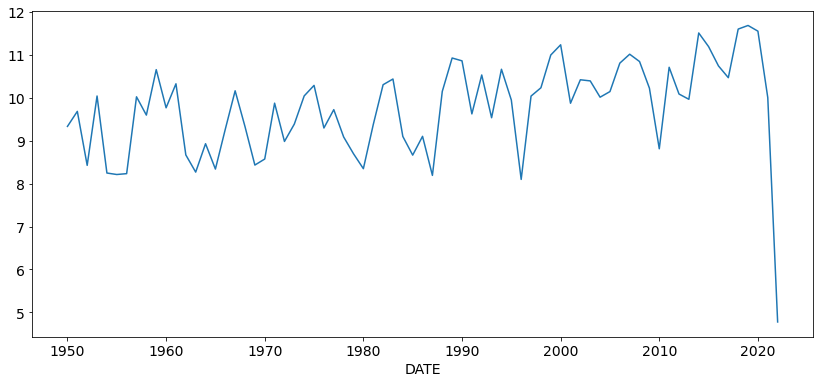

In [17]:
dfn.groupby(dfn.index.year)['temp'].mean().plot()

In [18]:
dfn.tail()

,STAID,SOUID,TG,Q_TG,temp
DATE,,,,,
2022-03-27,4005,133,85.0,0,8.5
2022-03-28,4005,133,96.0,0,9.6
2022-03-29,4005,133,75.0,0,7.5
2022-03-30,4005,133,51.0,0,5.1
2022-03-31,4005,21152,51.0,9,5.1


### Extract the Timestep and the Seasonal Dummies for the whole Dataset

In [19]:
#insert time step for regression analysis
dfn['timestep'] = range(len(dfn))
dfn.head(2)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/4029727242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['timestep'] = range(len(dfn))


,STAID,SOUID,TG,Q_TG,temp,timestep
DATE,,,,,,
1950-01-01,4005,133,-32.0,0,-3.2,0
1950-01-02,4005,133,10.0,0,1.0,1


In [20]:
#df_train['months']=df_train['months'].astype('int64')
#df_test['months']=df_test['months'].astype('int64')

In [21]:
# One-Hot-Encoding the month
seasonal_dummies= pd.get_dummies(dfn.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(dfn.index)

In [22]:
seasonal_dummies['month_2']=seasonal_dummies['month_2'].astype('int64')
seasonal_dummies['month_3']=seasonal_dummies['month_3'].astype('int64')
seasonal_dummies['month_4']=seasonal_dummies['month_4'].astype('int64')
seasonal_dummies['month_5']=seasonal_dummies['month_5'].astype('int64')
seasonal_dummies['month_6']=seasonal_dummies['month_6'].astype('int64')
seasonal_dummies['month_7']=seasonal_dummies['month_7'].astype('int64')
seasonal_dummies['month_8']=seasonal_dummies['month_8'].astype('int64')
seasonal_dummies['month_9']=seasonal_dummies['month_9'].astype('int64')
seasonal_dummies['month_10']=seasonal_dummies['month_10'].astype('int64')
seasonal_dummies['month_11']=seasonal_dummies['month_11'].astype('int64')
seasonal_dummies['month_12']=seasonal_dummies['month_12'].astype('int64')

In [23]:
seasonal_dummies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26388 entries, 1950-01-01 to 2022-03-31
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   month_2   26388 non-null  int64
 1   month_3   26388 non-null  int64
 2   month_4   26388 non-null  int64
 3   month_5   26388 non-null  int64
 4   month_6   26388 non-null  int64
 5   month_7   26388 non-null  int64
 6   month_8   26388 non-null  int64
 7   month_9   26388 non-null  int64
 8   month_10  26388 non-null  int64
 9   month_11  26388 non-null  int64
 10  month_12  26388 non-null  int64
dtypes: int64(11)
memory usage: 2.4 MB


In [24]:
# join the dummies with the df_train data frame
dfn = dfn.join(seasonal_dummies)
dfn.head(2)

,STAID,SOUID,TG,Q_TG,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,,
1950-01-01,4005,133,-32.0,0,-3.2,0,0,0,0,0,0,0,0,0,0,0,0
1950-01-02,4005,133,10.0,0,1.0,1,0,0,0,0,0,0,0,0,0,0,0


In [25]:
dfclean=dfn.drop(columns=['STAID','SOUID','TG','Q_TG'])
dfclean.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1950-01-01,-3.2,0,0,0,0,0,0,0,0,0,0,0,0
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0


# Train-Test-Split

In [26]:
df_train = dfclean[:-365]
df_test = dfclean[-365:]

In [27]:
df_train.shape, df_test.shape

((26023, 13), (365, 13))

In [28]:
df_train.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1950-01-01,-3.2,0,0,0,0,0,0,0,0,0,0,0,0
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0


# Model the Trend-Linear Regression

In [29]:
Xtrain = df_train.drop(['temp'], axis = 1) # matrix (or DataFrame)
ytrain = df_train[['temp']]# vector (or Series)

Xtest = df_test.drop(['temp'], axis = 1)
ytest = df_test[['temp']]

In [30]:
#Xtrain.info()

In [31]:
Xtrain.head(2)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1950-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1950-01-02,1,0,0,0,0,0,0,0,0,0,0,0


In [32]:
ytrain.head(2)

,temp
DATE,
1950-01-01,-3.2
1950-01-02,1.0


In [33]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((26023, 12), (26023, 1), (365, 12), (365, 1))

In [34]:
m = LinearRegression()

In [35]:
m.fit(Xtrain, ytrain)

LinearRegression()

In [36]:
base_LR_score=m.score(Xtrain, ytrain)
base_LR_score

0.7445716363691195

In [37]:
df_train['trend_seasonal'] = m.predict(Xtrain)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/912684361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend_seasonal'] = m.predict(Xtrain)


In [38]:
df_train.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,
1950-01-01,-3.2,0,0,0,0,0,0,0,0,0,0,0,0,-0.534198
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0,-0.534120


## Plot the original data and preliminary model

In [39]:
def plot_data(df, 
                   title='Remaining Temperature after Extracting Trend and Seasonality', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    
    Returns
    -------
    Plots the data
    '''
    
    df.plot()
    plt.title(title)
    plt.ylabel('Temperature in Celsius')#
#    if ylim:
#        plt.ylim(ymin=0)
    plt.show()

<AxesSubplot:xlabel='DATE'>

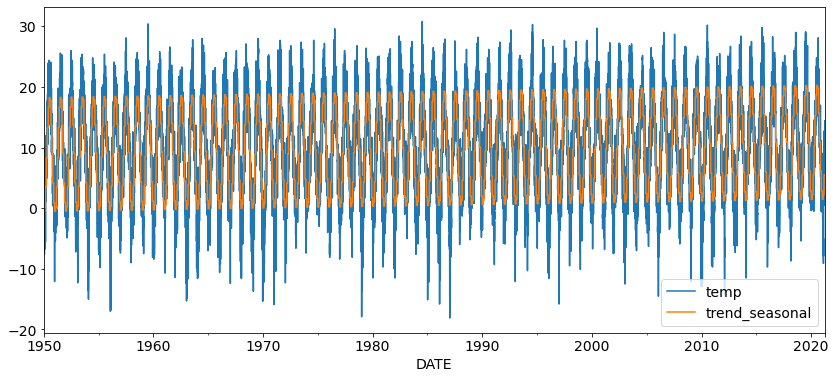

In [40]:
df_train[['temp', 'trend_seasonal']].plot()

(17532.0, 18717.0)

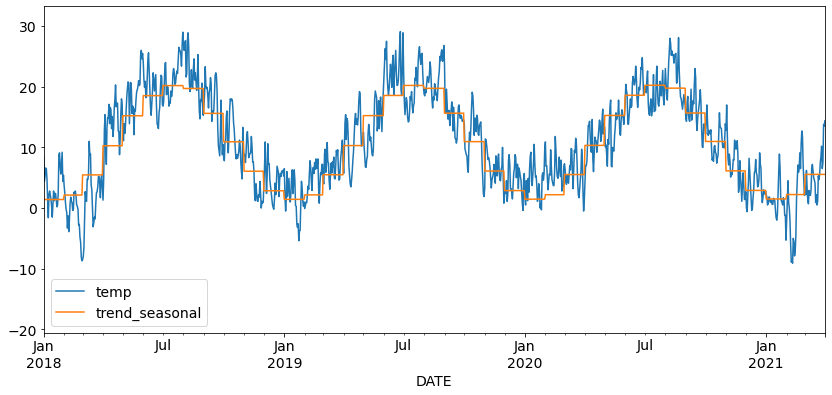

In [41]:
df_train[['temp', 'trend_seasonal']].plot()
plt.xlim(xmin='2018')


/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/1864889547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['remainder'] = df_train['temp'] - df_train['trend_seasonal']


<AxesSubplot:xlabel='DATE'>

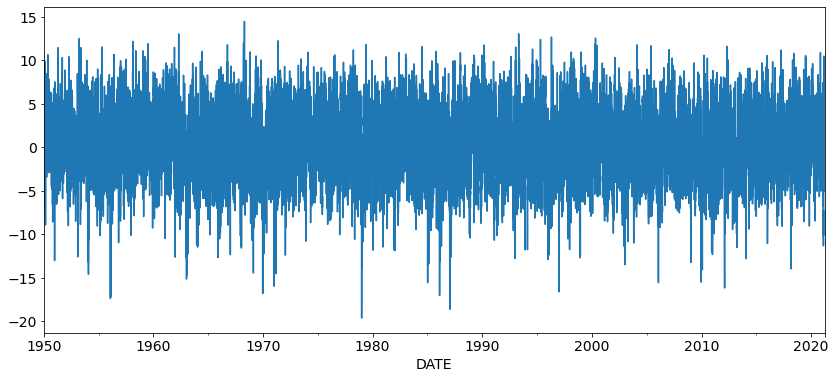

In [42]:
df_train['remainder'] = df_train['temp'] - df_train['trend_seasonal']

df_train['remainder'].plot()

(18262.0, 18717.0)

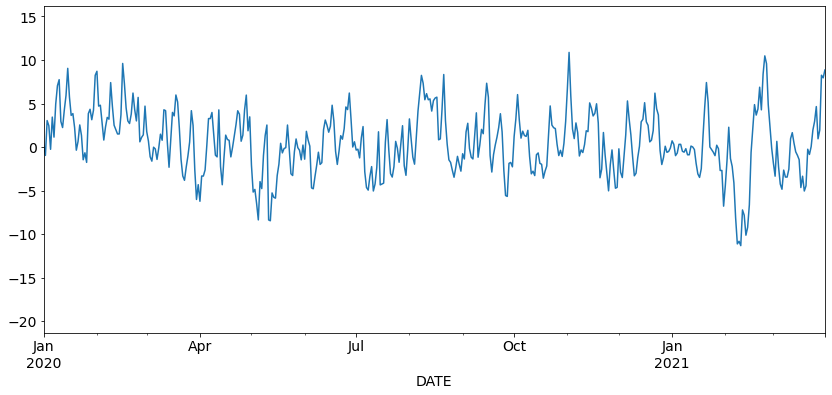

In [43]:
df_train['remainder'].plot()
plt.xlim(xmin='2020')

In [44]:
df_train["remainder"].std(), df_train["temp"].std()

(3.9716122157274687, 7.8583664563250935)

### Cross Validation on Regularized Model

In [45]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [46]:
# Create the time series split
time_series_split = ts_split.split(Xtrain, ytrain) 

In [47]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m, 
                         X=Xtrain, y=ytrain,
                         cv=time_series_split)
result

array([0.70424865, 0.74442989, 0.70818265, 0.73761257, 0.74931739])

In [48]:
result.mean()

0.7287582307749392

### Export Remainder to csv

In [49]:
df_train['remainder'].to_csv('df_train_remainder.csv')

In [50]:
pwd

'/Users/karenbolon/Documents/spiced_projects/sandbox_dir'

## Seasonal Decompose

### Data from 1950

In [51]:
sd = seasonal_decompose(df_train['temp'], model='additive')

# optional parameter: model="multiplicative" # this assumes trend * seasonality instead of trend + seasonality

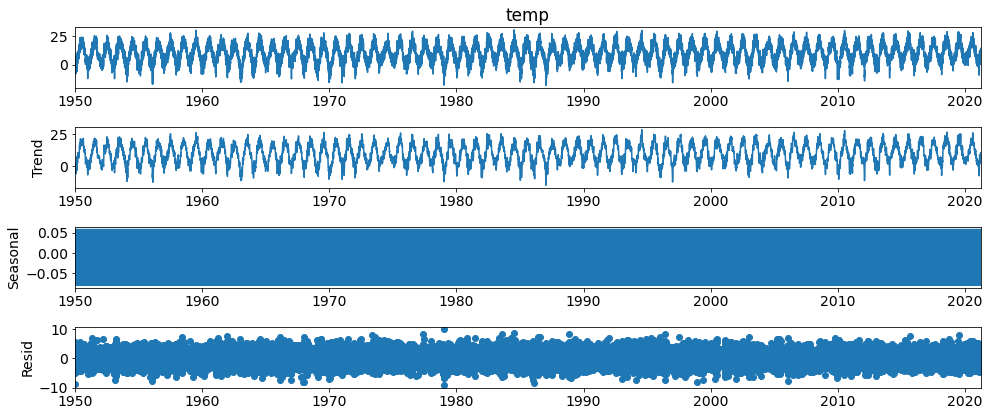

In [52]:
sd.plot()
None

<AxesSubplot:xlabel='DATE'>

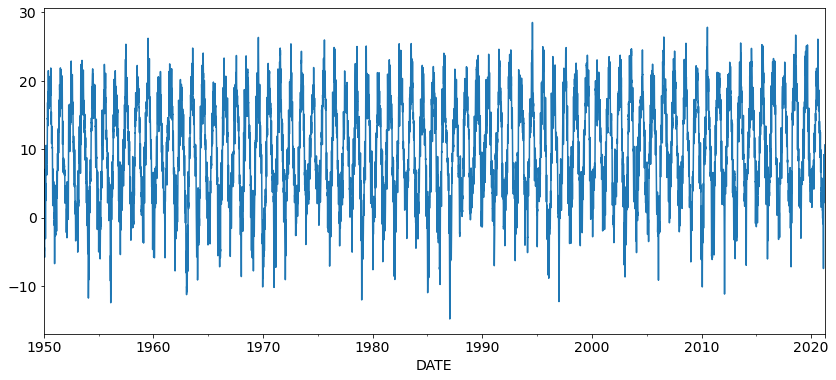

In [53]:
#another way to pull out the graphs individually
sd.trend.plot()

<AxesSubplot:xlabel='DATE'>

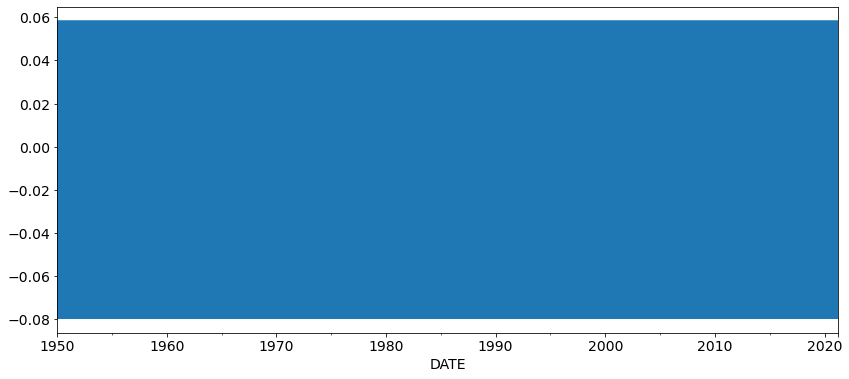

In [54]:
sd.seasonal.plot()

<AxesSubplot:xlabel='DATE'>

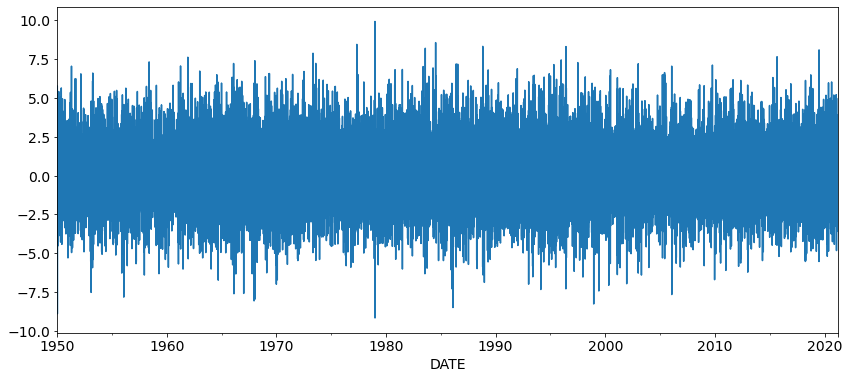

In [55]:
sd.resid.plot()

### Data from 2018

In [56]:
recent=df_train[df_train.index.year >= 2020]
recent.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
DATE,,,,,,,,,,,,,,,
2020-01-01,1.7,25567,0,0,0,0,0,0,0,0,0,0,0,1.457774,0.242226
2020-01-02,0.5,25568,0,0,0,0,0,0,0,0,0,0,0,1.457852,-0.957852


In [57]:
sd2 = seasonal_decompose(recent['temp'], model='additive')

# optional parameter: model="multiplicative" # this assumes trend * seasonality instead of trend + seasonality

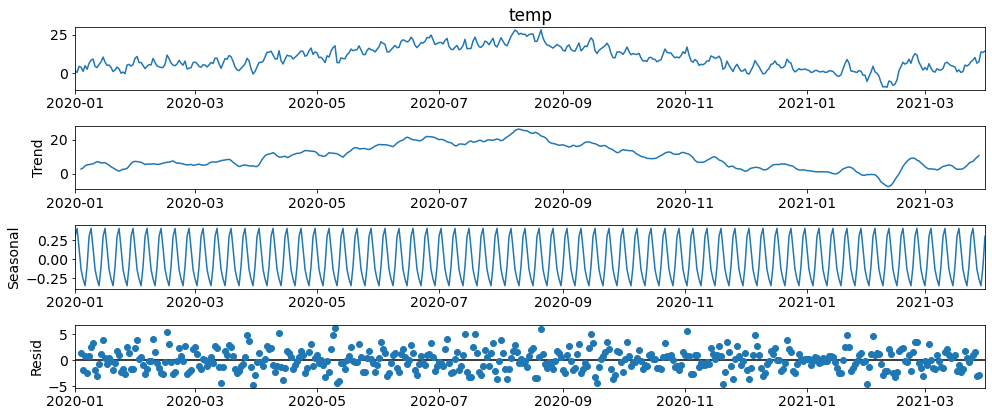

In [58]:
sd2.plot()
None

<AxesSubplot:xlabel='DATE'>

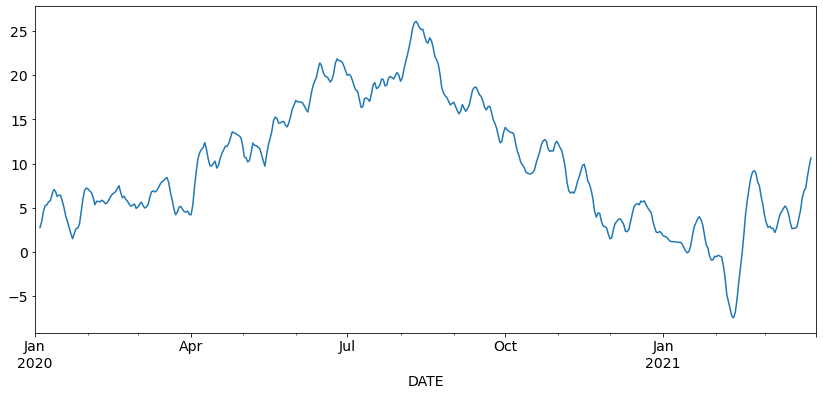

In [59]:
sd2.trend.plot()

<AxesSubplot:xlabel='DATE'>

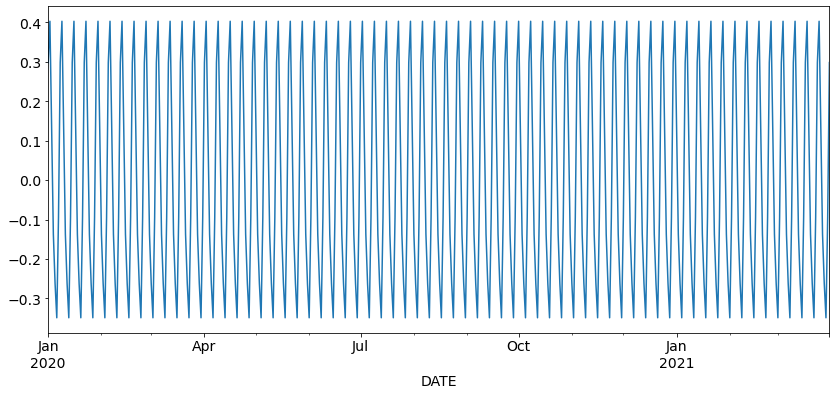

In [60]:
sd2.seasonal.plot()

<AxesSubplot:xlabel='DATE'>

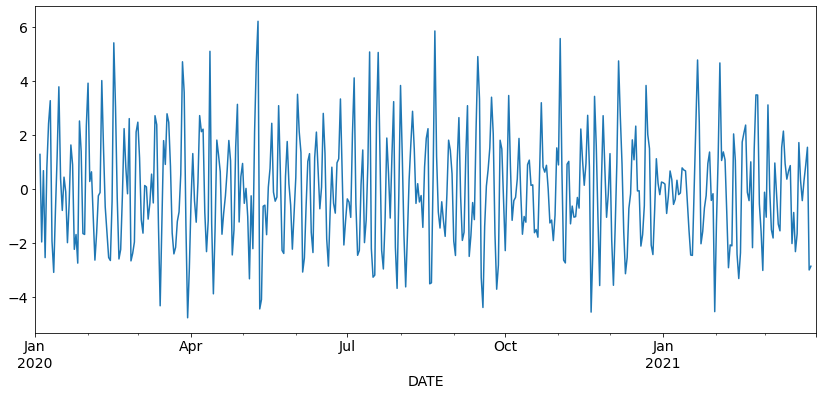

In [61]:
sd2.resid.plot()

# Modelling Autoregression

In [62]:
pwd

'/Users/karenbolon/Documents/spiced_projects/sandbox_dir'

In [63]:
dfr = pd.read_csv('./dfn_train_remainder.csv', index_col=['DATE'], parse_dates=['DATE'])
dfr.head(2)

,remainder
DATE,
1950-01-01,-2.665802
1950-01-02,1.534120


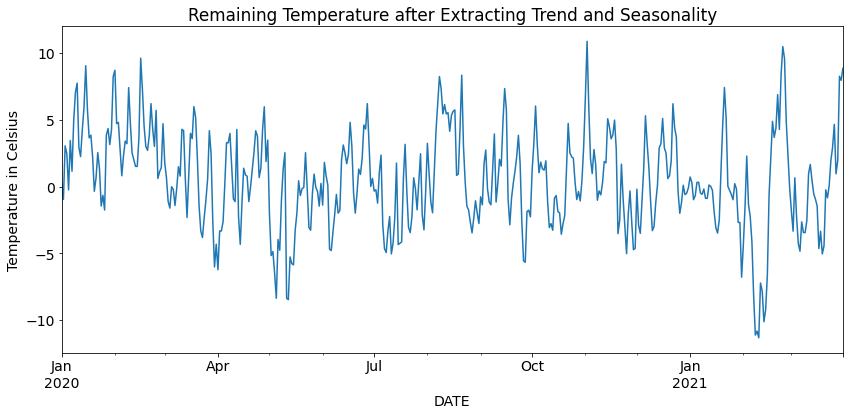

In [64]:
plot_data(dfr[dfr.index.year>=2020]['remainder'])


## Create a time-lagged input feature: lag1

In [65]:
#used this to calculate correlation only
#otherwise used df_train to continue (this adds the lags to the remainder data)
df_train['lag1'] = df_train['remainder'].shift(1)
df_train.dropna(inplace=True)
df_train.head(2)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/3851985792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['lag1'] = df_train['remainder'].shift(1)
/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
DATE,,,,,,,,,,,,,,,,
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0,-0.534120,1.534120,-2.665802
1950-01-03,2.8,2,0,0,0,0,0,0,0,0,0,0,0,-0.534042,3.334042,1.534120


# Run full model

In [66]:
# Assign X
X_full = df_train.drop(columns=['temp', 'trend_seasonal', 'remainder'])
y_full = df_train['temp']

In [67]:
#X_full.head()

In [68]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [69]:
# Create a new predictions column
df_train['predictions_full_model'] = m_full.predict(X_full)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/3771032906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['predictions_full_model'] = m_full.predict(X_full)


In [70]:
#df_train.tail()

# Plot the prediction vs temp for the training data

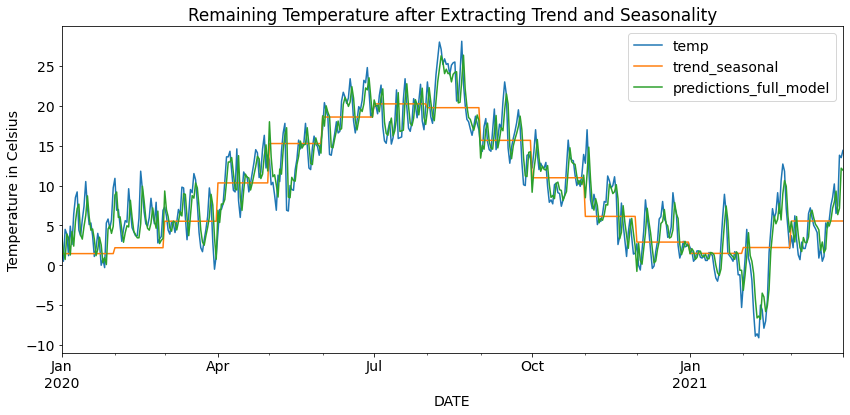

In [71]:
plot_data(df_train[df_train.index.year >= 2020][['temp', 'trend_seasonal', 'predictions_full_model']])

In [72]:
pd.DataFrame(m_full.coef_.reshape(1,13), columns=X_full.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,0.000078,0.749217,4.068222,8.843071,13.735707,17.065114,18.752004,18.198746,14.143117,9.458875,4.625389,1.411384,0.798221


### Correlation

In [73]:
df_train2=df_train[['remainder','lag1']]

In [74]:
df_train2.corr()

,remainder,lag1
remainder,1.000000,0.798074
lag1,0.798074,1.000000


### Autocorrelation

There is a strong correlation between the remainder and lag1.  Generally, we can use yesterday or today weather to predict today/tomorrow (approximately)

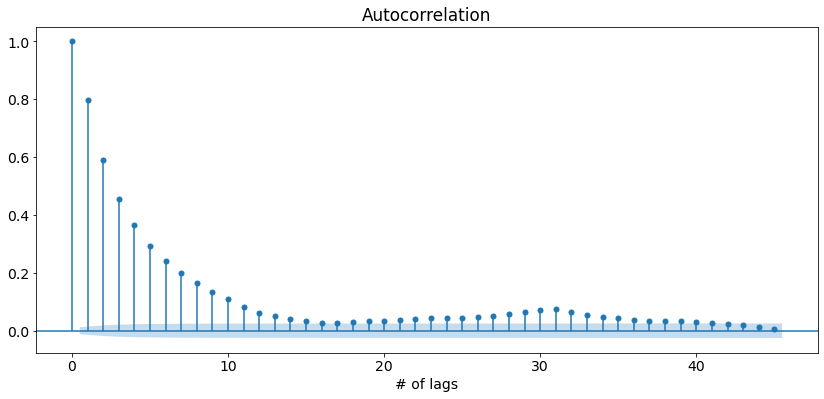

In [75]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dfr['remainder'])
plt.xlabel('# of lags');

### Partial Autocorrelation

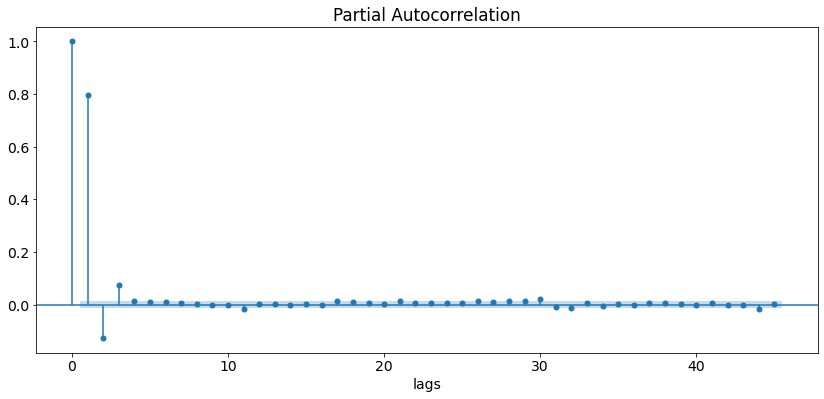

In [76]:
# Statsmodels provides a function called plot_pacf
# plot partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dfr['remainder'])
plt.xlabel('lags');

From the autocorrelation graph above, it appears that more lags would be beneficial however with the partial autocorrelation, it appears we should only use 1 lag. Therefore I use lag1.

### Plot remainder against lag1

<AxesSubplot:xlabel='lag1', ylabel='remainder'>

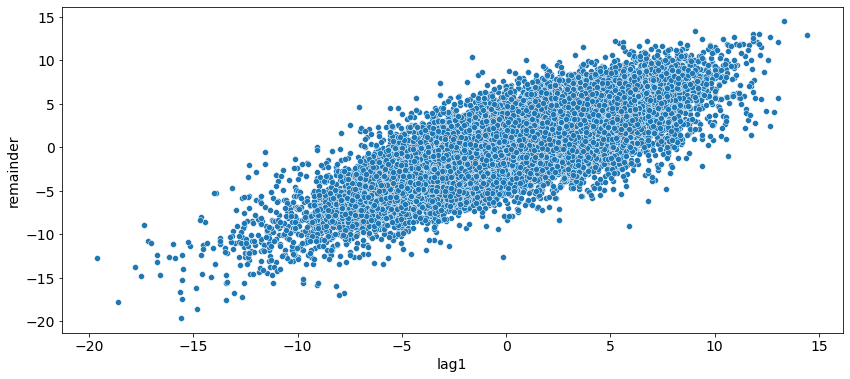

In [77]:
sns.scatterplot(x='lag1', y='remainder', data=df_train)

<AxesSubplot:xlabel='lag1', ylabel='remainder'>

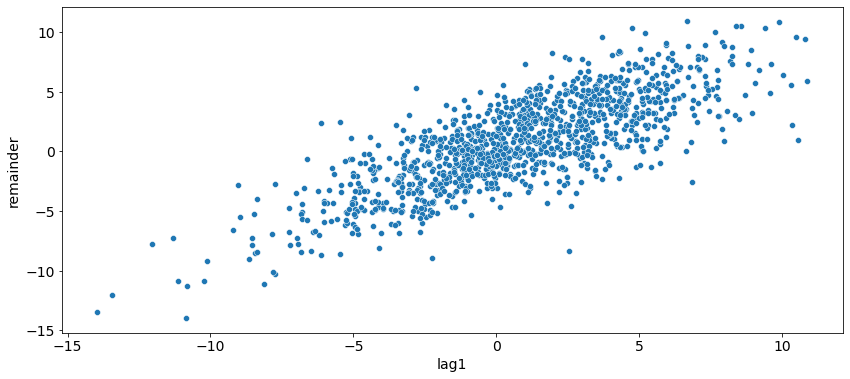

In [78]:
sns.scatterplot(x='lag1', y='remainder', data=df_train[df_train.index.year >= 2018])


### Autoregression (Linear Regression) lag1 on the remainder

In [79]:
df_train.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0,-0.534120,1.534120,-2.665802,-2.633278
1950-01-03,2.8,2,0,0,0,0,0,0,0,0,0,0,0,-0.534042,3.334042,1.534120,0.719266


In [80]:
# Assign X and y
X_lag = df_train[['lag1']]
y_lag = df_train['remainder']

In [81]:
X_lag.head(2)

,lag1
DATE,
1950-01-02,-2.665802
1950-01-03,1.534120


In [82]:
# Create and fit the model
m_lag = LinearRegression()
m_lag.fit(X_lag, y_lag)

LinearRegression()

In [83]:
# Create predictions
df_train['predictions_lag'] = m_lag.predict(X_lag)
df_train.head(2)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/3370824138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['predictions_lag'] = m_lag.predict(X_lag)


,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model,predictions_lag
DATE,,,,,,,,,,,,,,,,,,
1950-01-02,1.0,1,0,0,0,0,0,0,0,0,0,0,0,-0.534120,1.534120,-2.665802,-2.633278,-2.127319
1950-01-03,2.8,2,0,0,0,0,0,0,0,0,0,0,0,-0.534042,3.334042,1.534120,0.719266,1.224821


# Plot the prediction vs actual for the training data



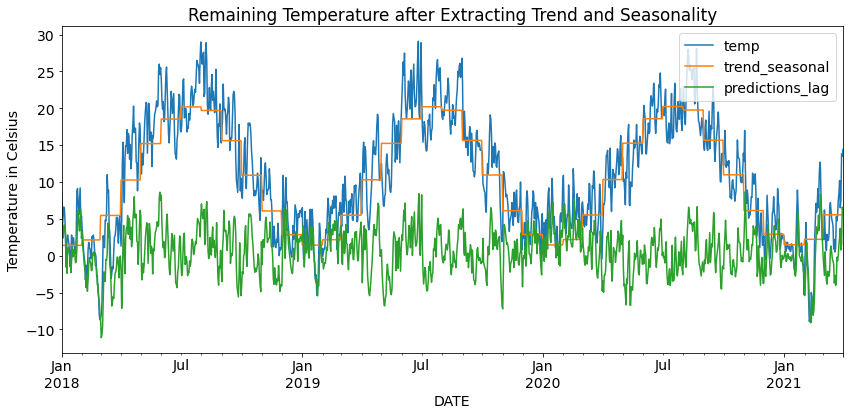

In [84]:
# Plot the original remainder and the prediction
plot_data(df_train[df_train.index.year >= 2018][['temp', 'trend_seasonal', 'predictions_lag']])


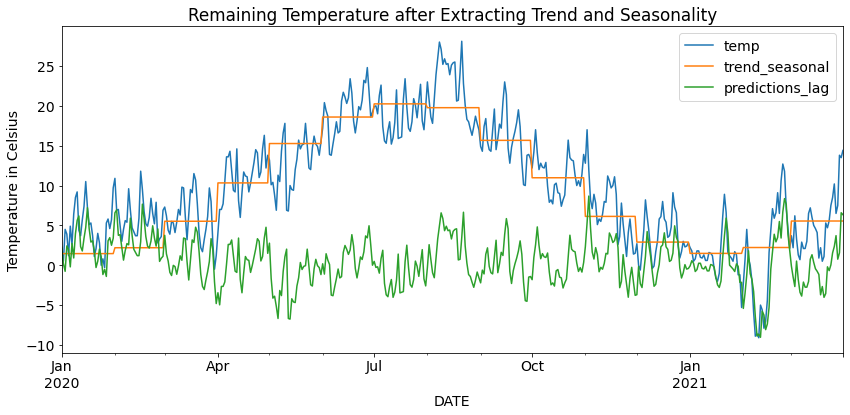

In [85]:
# Plot the original remainder and the prediction
plot_data(df_train[df_train.index.year >= 2020][['temp', 'trend_seasonal', 'predictions_lag']])

<AxesSubplot:xlabel='DATE'>

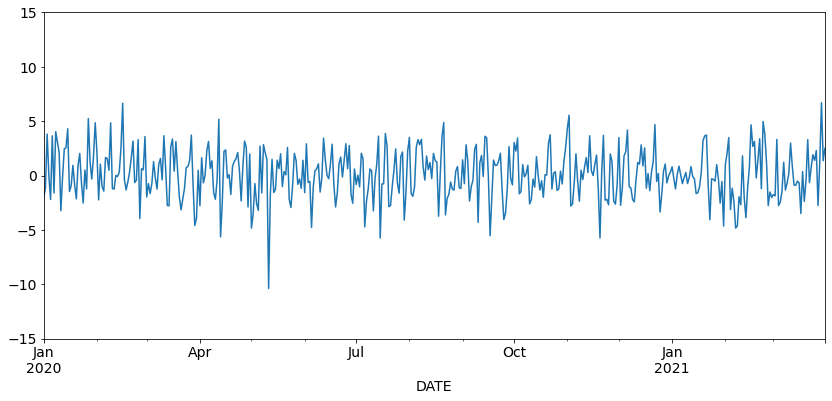

In [86]:
# Is the remainder prediction error smaller than the remainder itself?
(df_train[df_train.index.year >= 2020]['remainder'] - df_train[df_train.index.year >= 2020]['predictions_lag']).plot(ylim=[-15,15])

# Evaluate the Model-CrossValidate Time Series

In [87]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [88]:
# Create the time series split
time_series_split2 = ts_split.split(X_full, y_full) 

In [89]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split2)
result

array([0.9036443 , 0.90665939, 0.89643492, 0.91095542, 0.91296527])

In [90]:
result.mean()

0.9061318600935726

# Augmented Dickey-Fuller Test

Based on the significance level it associates with its statistical measure, you decide whether it's stationary or not.

In [91]:
gaussian_noise = np.random.normal(size=1000)
statsmodels.tsa.stattools.adfuller(gaussian_noise)

(-32.1730198922633,
 0.0,
 0,
 999,
 {'1%': -3.4369127451400474,
  '5%': -2.864437475834273,
  '10%': -2.568312754566378},
 2867.3620153668603)

In [92]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=0.01; CI=99%) 
            {round(levels['5%'],2)} (p=0.05; CI=95%)
            {round(levels['10%'],2)} (p=0.1 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

In [93]:
print_adf(gaussian_noise)

   
            adf: -32.17
            p: 0.0 
            used lag: 0 
            number of observations: 999
            -3.44 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 2867.3620153668603
            


The first number is the ADF-Stats, the more negative it is, the more confident we are that we don't have a unit root (the series is stationary).

In the lookup table (dictionary), the smallest value is -3.44 for the adf_stats. Hence from -32.75 < -3.4 we can reject the null hypothesis with a confidence level of more than 99% (p=0.01, highly significant result).

Think about the possible values of the ADF-Stats to be a random variable. It has the assumption that a time series is not stationary. So if the value you get from the test is in the centre of the distribution that describes the ADF-Stats variable, then your time series is NOT stationary. Therefore, we would want our remainder's ADF-Stats value to be somewhere in the outer parts of that distribution. If you choose a confidence interval of 95%, you are saying you covered 95% of ADF outcomes inside the range and any value outside of that is quite significantly different (meaning it's stationary).

If you chose 95%, then your p-value is 0.05.

In [94]:
ar_model = AutoReg(endog=df_train['remainder'], lags=1).fit()

/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [95]:
ar_model.summary()

/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                26022
Model:                     AutoReg(1)   Log Likelihood              -59627.303
Method:               Conditional MLE   S.D. of innovations              2.393
Date:                Sun, 01 May 2022   AIC                              1.745
Time:                        10:14:45   BIC                              1.746
Sample:                    01-03-1950   HQIC                             1.746
                         - 03-31-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.015      0.016      0.987      -0.029       0.029
remainder.L1     0.7982      0.004    213.665      0.000       0.791       0.805
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2529           +0.0000j            1.2529            0.0000
-----------------------------------------------------------------------------
"""

**Observations:**

The log-likelihood value of a regression model is a way to measure the goodness of fit for a model. The higher the value of the log-likelihood, the better a model fits a dataset. My log likelihood shows it isn't a great fit.  We would want it closer to 0.


The high p value for the intercept suggests that we should probably try to improve the model.

AIC-small number and is ok

In [96]:
df_train['ar_prediction'] = ar_model.predict()

/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/1263250120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ar_prediction'] = ar_model.predict()


In [97]:
df_train.dropna(inplace = True)

/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# Is the Remainder Stationary?

<AxesSubplot:xlabel='DATE'>

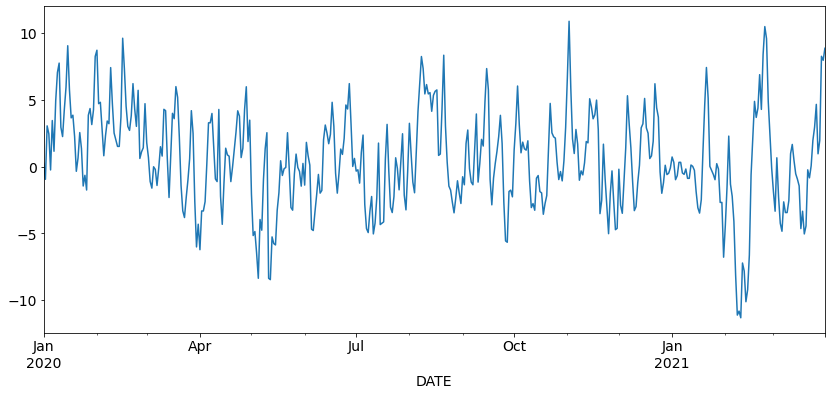

In [98]:
df_train[df_train.index.year >= 2020].remainder.plot()

In [99]:
print_adf(df_train.remainder)

   
            adf: -23.23
            p: 0.0 
            used lag: 31 
            number of observations: 25989
            -3.43 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 118428.68500878128
            


# Test the Model

In [100]:
X_test = df_test.drop(columns=['temp'])
y_test = df_test['temp']

In [101]:
df_test['trend_seasonal'] = m.predict(X_test)
df_test.head(2)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/1273522552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['trend_seasonal'] = m.predict(X_test)


,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,
2021-04-01,10.6,26023,0,0,1,0,0,0,0,0,0,0,0,10.356676
2021-04-02,5.7,26024,0,0,1,0,0,0,0,0,0,0,0,10.356754


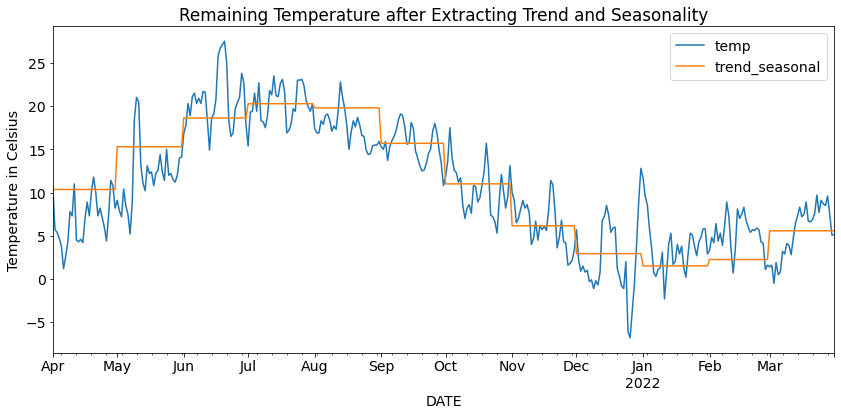

In [102]:
plot_data(df_test[['temp', 'trend_seasonal']], ylim=False)

In [103]:
#Calculate the remainder for the test set.
df_test['remainder'] = df_test['temp'] - df_test['trend_seasonal']

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/2156635885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['remainder'] = df_test['temp'] - df_test['trend_seasonal']


In [104]:
#df_test.head(2)

In [105]:
#And finally the lag for the remainder as our additional feature for the AR model.
df_test['lag1'] = df_test['remainder'].shift(1)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/1995274268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag1'] = df_test['remainder'].shift(1)


In [106]:
#df_test.head(2)

In [107]:
# Assign X_full
X_full = df_test.drop(columns=['temp', 'trend_seasonal', 'remainder'])

In [108]:
X_full.head(2)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
DATE,,,,,,,,,,,,,
2021-04-01,26023,0,0,1,0,0,0,0,0,0,0,0,NaN
2021-04-02,26024,0,0,1,0,0,0,0,0,0,0,0,0.243324


In [109]:
df_train.tail(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model,predictions_lag,ar_prediction
DATE,,,,,,,,,,,,,,,,,,,
2021-03-30,13.5,26021,0,1,0,0,0,0,0,0,0,0,0,5.549148,7.950852,8.250930,12.176927,6.585799,6.585854
2021-03-31,14.4,26022,0,1,0,0,0,0,0,0,0,0,0,5.549226,8.850774,7.950852,11.937477,6.346294,6.346342


In [110]:
#Filling in the missing value from the beginning of the test lag. Use the last date from training data
X_full.loc['2021-04-01', 'lag1'] = df_train.loc['2021-03-31', 'remainder']

In [111]:
# Create the predictions
df_test['predictions_full_model'] = m_full.predict(X_full)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/2799633638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions_full_model'] = m_full.predict(X_full)


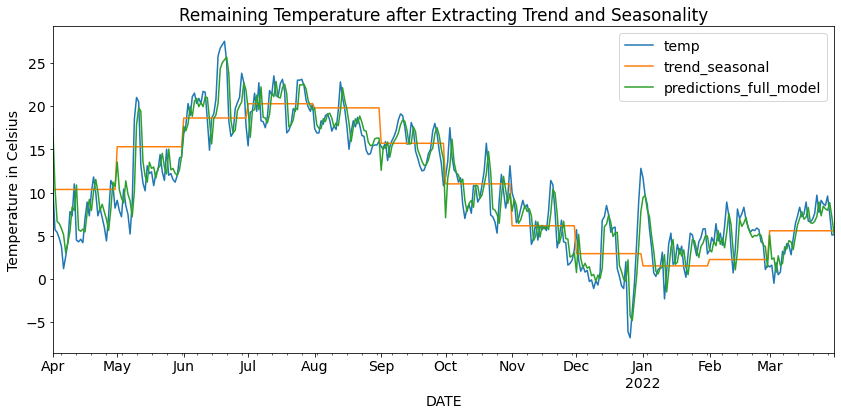

In [112]:
plot_data(df_test[['temp', 'trend_seasonal', 'predictions_full_model']], ylim=False)

In [113]:
# Create the complete dataset and plot it
df_full = df_train[['temp', 'trend_seasonal', 'predictions_full_model']].append(df_test[['temp', 'trend_seasonal', 'predictions_full_model']])

In [114]:
df_full.head(2)

,temp,trend_seasonal,predictions_full_model
DATE,,,
1950-01-03,2.8,-0.534042,0.719266
1950-01-04,-0.1,-0.533964,2.156080


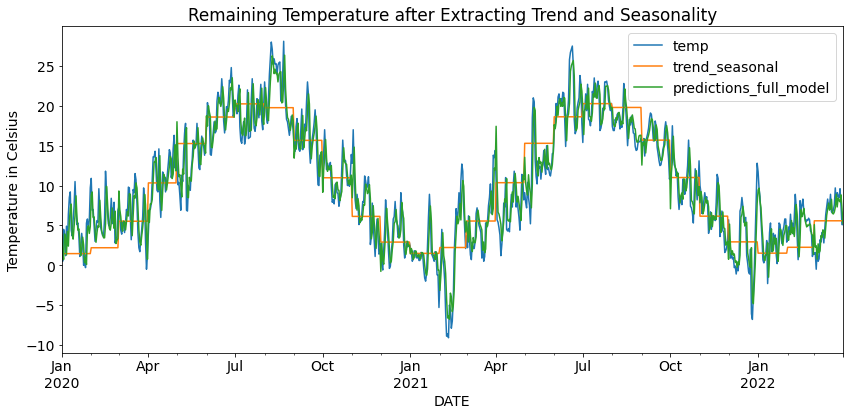

In [115]:
plot_data(df_full[df_full.index.year >= 2020])

In [116]:
print(f"""
{m_full.score(X_full, df_test['temp'])}
{m.score(X_test, df_test['temp'])}
""")


0.9066288980623268
0.752101015973936



# Predict the future

In [117]:
df_test.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,
2021-04-01,10.6,26023,0,0,1,0,0,0,0,0,0,0,0,10.356676,0.243324,NaN,17.430740
2021-04-02,5.7,26024,0,0,1,0,0,0,0,0,0,0,0,10.356754,-4.656754,0.243324,10.560171


In [118]:
temp_combined = df_train.append(df_test)
temp_combined.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model,predictions_lag,ar_prediction
DATE,,,,,,,,,,,,,,,,,,,
1950-01-03,2.8,2,0,0,0,0,0,0,0,0,0,0,0,-0.534042,3.334042,1.534120,0.719266,1.224821,1.224717
1950-01-04,-0.1,3,0,0,0,0,0,0,0,0,0,0,0,-0.533964,0.433964,3.334042,2.156080,2.661417,2.661356


In [119]:
temp=temp_combined.drop(columns='predictions_lag')

In [120]:
# Re-train the model on the whole dataset
X_combined = temp.drop(columns=['temp', 'trend_seasonal', 'remainder', 'predictions_full_model','ar_prediction'])
y_combined = temp['temp']

In [121]:
X_combined.tail(2)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
DATE,,,,,,,,,,,,,
2022-03-30,26386,0,1,0,0,0,0,0,0,0,0,0,1.922492
2022-03-31,26387,0,1,0,0,0,0,0,0,0,0,0,-0.477586


In [122]:
#Fill in the missing value from the beginning of the test set
X_combined.loc['2021-04-01', 'lag1'] = df_train.loc['2021-03-31', 'remainder']

In [123]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [124]:
X_combined.tail(1)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
DATE,,,,,,,,,,,,,
2022-03-31,26387,0,1,0,0,0,0,0,0,0,0,0,-0.477586


## Create a single future step data.

In [125]:
# What is the first date in the future? --> 2022-04-01
timestep = temp['timestep'].max() + 1
months = [0] * 11
lag1 = temp.loc['2022-03-31', 'remainder']

In [126]:
timestep, months, lag1

(26388, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -0.4776639745341962)

In [127]:
X_future = [timestep]

X_future

[26388]

In [128]:
X_future.extend(months)
X_future

[26388, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [129]:
X_future.append(lag1)
X_future

[26388, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.4776639745341962]

In [130]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,26388,0,0,0,0,0,0,0,0,0,0,0,-0.477664


In [131]:
# Prediction for 2022-04-01
# m_full.predict(X_future) is somehow a better idea.
X_future['future_pred']=m_combined.predict(X_future)
X_future.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,future_pred
0,26388,0,0,0,0,0,0,0,0,0,0,0,-0.477664,1.168134


In [132]:
# How does this look like for 2022-04-03? So one more step to the future.
timestep =  temp['timestep'].max() + 2
months = [1] + [0]*10
lag1 = 0 
# This is too far in the future to calculate the lag.

In [133]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag1]])
X_future_2.columns = X_combined.columns
X_future_2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,26389,1,0,0,0,0,0,0,0,0,0,0,0


In [134]:
m_combined.predict(X_future_2)

array([2.30440075])

# ARIMA

The training data

The order:

p - AR part (regression on the X data, 0 to 3) - FIRST (HYPER) PARAMETER
d - I (0 or 1) - SECOND (HYPER) PARAMETER
q - MA (of the residuals!!, 0 to 3) = THIRD (HYPER) PARAMETER

In [135]:
arima = ARIMA(endog= df_train['remainder'], order = (1,0,3)).fit()

/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/karenbolon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [136]:
df_train.columns

Index(['temp', 'timestep', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'trend_seasonal', 'remainder', 'lag1',
       'predictions_full_model', 'predictions_lag', 'ar_prediction'],
      dtype='object')

In [137]:
df_train['arima_prediction'] = arima.predict()

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/2465012476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['arima_prediction'] = arima.predict()


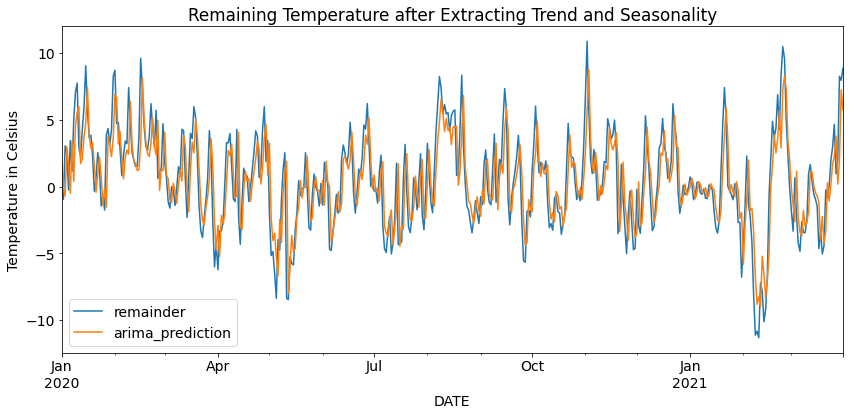

In [138]:
plot_data(df_train[df_train.index.year >= 2020][['remainder', 'arima_prediction']])

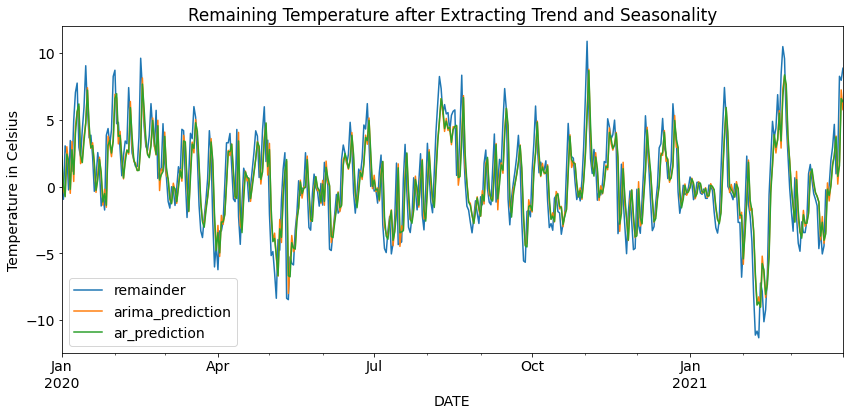

In [139]:
plot_data(df_train[df_train.index.year >= 2020][['remainder', 'arima_prediction', 'ar_prediction']])

In [140]:
ar_error = round(mean_absolute_error(df_train['remainder'], df_train['ar_prediction']),2)
arima_error = round(mean_absolute_error(df_train['remainder'], df_train['arima_prediction']),2)

In [141]:
f'Mean absolute error for Auto Regression: {ar_error} and it was improved to {arima_error} with ARIMA'

'Mean absolute error for Auto Regression: 1.87 and it was improved to 1.85 with ARIMA'

In [142]:
df_train.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model,predictions_lag,ar_prediction,arima_prediction
DATE,,,,,,,,,,,,,,,,,,,,
1950-01-03,2.8,2,0,0,0,0,0,0,0,0,0,0,0,-0.534042,3.334042,1.534120,0.719266,1.224821,1.224717,0.000755
1950-01-04,-0.1,3,0,0,0,0,0,0,0,0,0,0,0,-0.533964,0.433964,3.334042,2.156080,2.661417,2.661356,2.661134


In [143]:
### For the full temp and talking about real temp
df_train['full_pred_arima'] = df_train['trend_seasonal']+ df_train['arima_prediction']

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/2193095490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['full_pred_arima'] = df_train['trend_seasonal']+ df_train['arima_prediction']


In [144]:
df_train.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model,predictions_lag,ar_prediction,arima_prediction,full_pred_arima
DATE,,,,,,,,,,,,,,,,,,,,,
1950-01-03,2.8,2,0,0,0,0,0,0,0,0,...,0,0,-0.534042,3.334042,1.534120,0.719266,1.224821,1.224717,0.000755,-0.533287
1950-01-04,-0.1,3,0,0,0,0,0,0,0,0,...,0,0,-0.533964,0.433964,3.334042,2.156080,2.661417,2.661356,2.661134,2.127170


In [145]:
df_train.columns

Index(['temp', 'timestep', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'trend_seasonal', 'remainder', 'lag1',
       'predictions_full_model', 'predictions_lag', 'ar_prediction',
       'arima_prediction', 'full_pred_arima'],
      dtype='object')

In [146]:
base_model_error = round(mean_absolute_error(df_train['temp'], df_train['trend_seasonal']))
full_model_error = round(mean_absolute_error(df_train['temp'], df_train['predictions_full_model']))
arima_error = round(mean_absolute_error(df_train['temp'], df_train['full_pred_arima']))

In [147]:
f'Mean absolute error for the base model {base_model_error}, the  Auto Regression: {ar_error} and  ARIMA {arima_error}'

'Mean absolute error for the base model 3, the  Auto Regression: 1.87 and  ARIMA 2'

In [148]:
df_train['de_seasoned'] = df_train['temp'] - df_train['trend_seasonal']

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/615710839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['de_seasoned'] = df_train['temp'] - df_train['trend_seasonal']


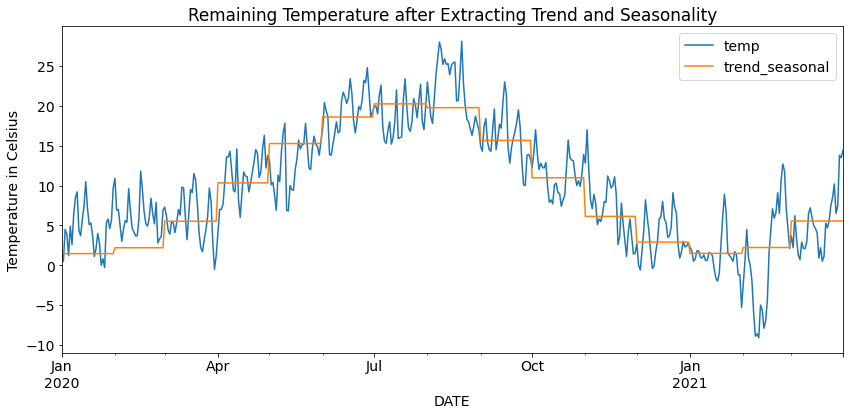

In [149]:
plot_data(df_train[df_train.index.year >= 2020][['temp', 'trend_seasonal']])

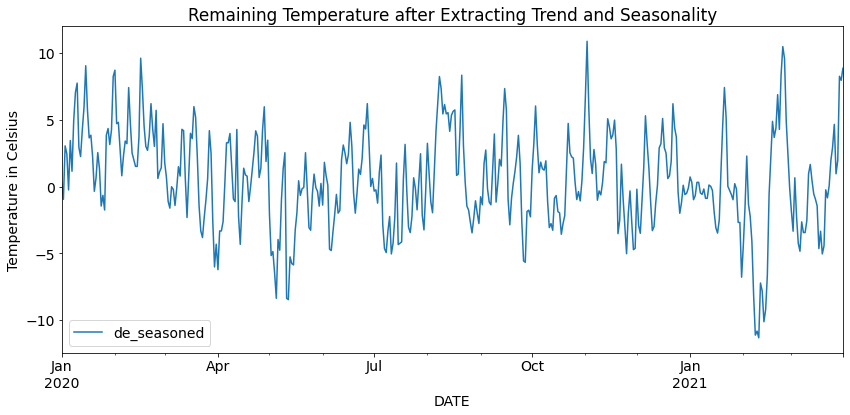

In [150]:
plot_data(df_train[df_train.index.year >= 2020][['de_seasoned']])

In [151]:
df_train['diff'] = df_train['de_seasoned'].diff(periods = 1)

/var/folders/xr/cfvb87194137h9lmpcxwzc5c0000gn/T/ipykernel_10779/4131463105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['diff'] = df_train['de_seasoned'].diff(periods = 1)


In [152]:
df_train[['de_seasoned', 'diff']].head(2)

,de_seasoned,diff
DATE,,
1950-01-03,3.334042,NaN
1950-01-04,0.433964,-2.900078


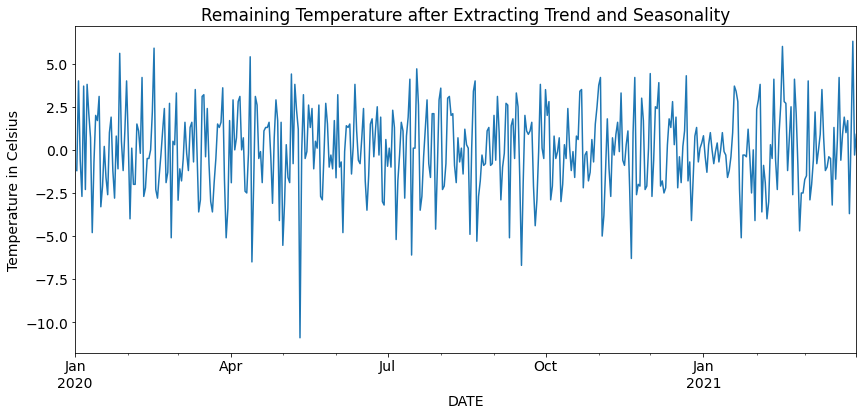

In [153]:
plot_data(df_train[df_train.index.year >= 2020]['de_seasoned'].diff(periods = 1)) # d: how many time lags of differencing needed to reach stationarity